In [1]:
import jax
import jax.numpy as jnp
# Set double precision
jax.config.update("jax_enable_x64", True)
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_affine_set
from jax.experimental.ode import odeint
import numpy as np
import cvxpy as cp
from functools import partial
from sklearn.utils.extmath import randomized_svd
from utils.ssm import DelaySSM
from utils.plotting import plot_trajectories, plot_fluid_results
from utils.misc import polynomial_features, trajectories_derivatives

# Simulate simplified fluid model

\begin{gathered}
\dot{x}_1=\mu x_1-\omega x_2+A x_1 x_3 \\
\dot{x}_2=\omega x_1+\mu x_2+A x_2 x_3 \\
\varepsilon \dot{x}_3=-\left(x_3-x_1^2-x_2^2\right)
\end{gathered}

In [2]:
# Define the example slow-fast system
def simple_fluid_system(x, t, μ, ω, A, ε):
    x1, x2, x3 = x
    dx1dt = μ * x1 - ω * x2 + A * x1 * x3
    dx2dt = ω * x1 + μ * x2 + A * x2 * x3
    dx3dt = -(x3 - x1**2 - x2**2) / ε
    return jnp.array([dx1dt, dx2dt, dx3dt])


# Parameters
μ = 0.1
ω = 1.0
A = -0.1
ε = 0.1
args = (μ, ω, A, ε)

# Check Jacobian of linear part of the system
func = partial(simple_fluid_system, t=0, μ=μ, ω=ω, A=A, ε=ε)
J = jax.jacobian(func, argnums=0)
print('Eigenvalues of linear part of dynamics: ', jnp.linalg.eigh(J(jnp.array([0., 0., 1.])))[0])

INFO   2025-04-08 21:46:56 xla_bridge Unable to initialize backend 'cuda': 
INFO   2025-04-08 21:46:56 xla_bridge Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO   2025-04-08 21:46:56 xla_bridge Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Eigenvalues of linear part of dynamics:  [-10.   0.   0.]


# Collect data

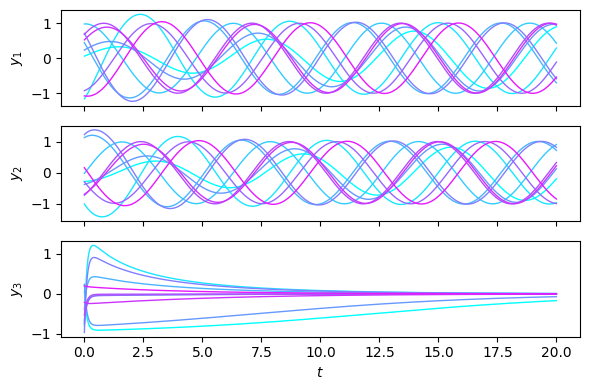

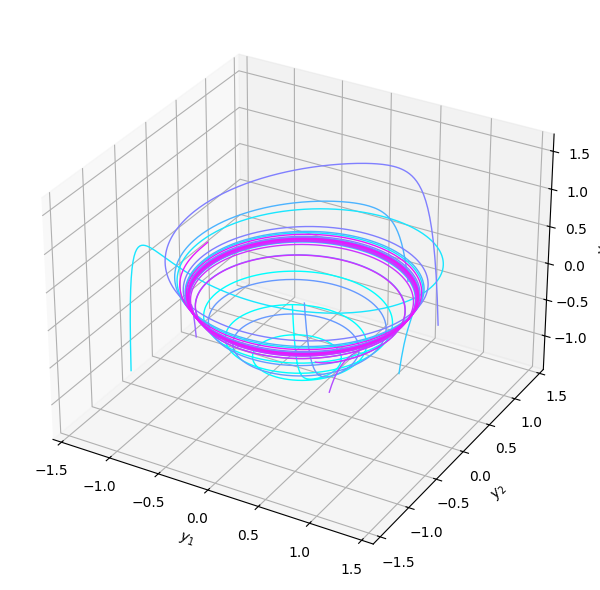

In [10]:
# Time points for integration
T = 20.0       # total time
N = 1000       # number of time points
ts = jnp.linspace(0, T, N)

# Simulate the system for several random initial conditions
rnd_key = jax.random.PRNGKey(0)
N_train = 10
x0s12 = jax.random.uniform(rnd_key, shape=(2, N_train), minval=-1.25, maxval=1.25)
x0s3 = jax.random.uniform(rnd_key, shape=(1, N_train), minval=0.0, maxval=1.25)
x0s = jnp.concatenate([x0s12, x0s3], axis=0)
train_trajs = []
for i in range(N_train):
    x0 = x0s[:, i]
    xs = odeint(simple_fluid_system, x0, ts, *args, rtol=1e-9, atol=1e-9, mxstep=10000)
    train_trajs.append(xs.T)
train_trajs = jnp.array(train_trajs)

# Center around the (unstable) equilibrium point
train_trajs = train_trajs - jnp.array([0, 0, 1])[None, :, None]
plot_trajectories(train_trajs, ts)

# Find optimal (oblique) linear projection

Here, we can directly perform optimization according to Equation (31) from the paper:
$$
\begin{aligned}
\min _{\mathbf{V}_{\text {opt}}, \mathbf{R}} & \quad \left\|\mathbf{V}_{\text {opt}}^{\top} \dot{\mathcal{Y}}-\mathbf{R}\left(\mathbf{V}_{\text{opt}}^{\top} \mathcal{Y}\right)^{1: n_r}\right\|^2 \\
\text{s.t.} & \quad \mathbf{V}_{\text{opt}}^{\top} \mathbf{V}_{\mathrm{E}}=\mathbf{I},
\end{aligned}
$$
such that we find the optimal (linear) projection and reduced dynamics right away.

In [32]:
# Hyperparameters
n = 2     # dimension of the slow manifold
n_r = 3   # polynomial order of reduced dynamics
n_w = 3   # polynomial order of parameterization map

# We obtain the number of polynomial features for the given order for the reduced dynamics
m_r = polynomial_features(jnp.zeros(n), n_r, 1).shape[1]

# Data
p = train_trajs.shape[1]
Y = train_trajs.transpose(1, 0, 2).reshape(p, -1)  # p x N_traj*len(t) := p x N
Y_dot = trajectories_derivatives(train_trajs, ts)
Y_dot = Y_dot.transpose(1, 0, 2).reshape(p, -1)  # p x N_traj*len(t) := p x N


def V2R(V_n, n_r, reg=1e-6):
    VnY = V_n.T @ Y               # n x N
    Vn_dotY = V_n.T @ Y_dot       # n x N
    Phi = polynomial_features(VnY.T, n_r, 1).T  # m_r x N

    # Compute R using normal equations without explicit inverse
    Phi_PhiT = jnp.dot(Phi, Phi.T) + reg * jnp.eye(Phi.shape[0])  # m_r x m_r
    B = jnp.dot(Vn_dotY, Phi.T)  # p x m_r
    R_T = jnp.linalg.solve(Phi_PhiT, B.T)  # m_r x p
    R = R_T.T  # transpose back to get p x m_r

    return R


def objective(VR, reg=1e-6):
    V_n = VR[:p]  # p x n
    R = VR[p:].T  # n x m_r

    VnY = V_n.T @ Y  # n x N
    Vn_dotY = V_n.T @ Y_dot  # n x N
    Phi = polynomial_features(VnY.T, n_r, 1).T  # m_r x N

    # Compute residual
    residual = Vn_dotY - jnp.dot(R, Phi)  # p x N

    # Return Frobenius norm squared
    cost = jnp.sum(residual ** 2) + reg * jnp.sum(R ** 2)
    return cost


# We use JAXOPT projected gradient descent optimizer as we no longer need the on manifold optimization
V_n_svd, _, _ = randomized_svd(np.asarray(Y), n_components=n)
V_n_init = V_n_svd @ jnp.linalg.inv(V_n_svd.T @ V_n_svd)
R_init = V2R(V_n_init, n_r)

init_params = jnp.vstack([V_n_init, R_init.T])
optimizer = ProjectedGradient(fun=objective, projection=projection_affine_set, implicit_diff=False)
A_constraint = jnp.hstack([V_n_svd.T, jnp.zeros((n, m_r))])
b_constraint = jnp.eye(n)
result = optimizer.run(init_params=init_params, hyperparams_proj=(A_constraint, b_constraint))
V_n_opt = result.params[:p]
R_opt = result.params[p:].T
print('Solved in ', result.state.iter_num, ' iterations')

Solved in  300  iterations


In [33]:
# Check constraints are satisfied
A_constraint @ result.params - b_constraint

Array([[-1.11022302e-16,  5.50317306e-17],
       [ 1.92281244e-17,  4.44089210e-16]], dtype=float64)

In [39]:
# Note that the parametrization map requires some more care here
# essentially, for x = (0, 0) to correspond to y = (0, 0, 0) the data needs to be uncentered
# else we would have to add an intercept to the parametrization map

train_trajs_uncentered = train_trajs + jnp.array([0, 0, 1])[None, :, None]
Y_param = train_trajs_uncentered.transpose(1, 0, 2).reshape(p, -1)

m_w = polynomial_features(Y.T @ V_n_opt, n_w, 2).shape[1]
W_nl = cp.Variable((p, m_w))
W_nl_reg = 0
param_objective = cp.Minimize(
            cp.sum_squares(Y_param - V_n_svd @ V_n_opt.T @ Y - W_nl @ polynomial_features(Y.T @ V_n_opt, n_w, 2).T) +
            W_nl_reg * cp.sum_squares(W_nl)
            )
constraints = [V_n_opt.T @ W_nl == jnp.zeros((n, m_w))]
problem = cp.Problem(param_objective, constraints)
problem.solve()
W_n_opt = V_n_svd
W_nl_opt = jnp.array(W_nl.value)
print('Status: ', problem.status)

Status:  optimal


# Compare with Vanilla SSM predictions

In [35]:
delay_ssm = DelaySSM(aut_trajs_obs=train_trajs,
                     SSMDim=2,
                     SSMOrder=5,
                     ROMOrder=5,
                     N_delay=0,
                     N_obs_delay=None,  # no reparametrization
                     ts=ts,
                     orthogonalize=False)  # orthogonalize the basis functions

INFO   2025-04-08 22:06:21 ridge Transforming data
INFO   2025-04-08 22:06:21 ridge Skipping CV on ridge regression
INFO   2025-04-08 22:06:21 ridge Fitting regression model
INFO   2025-04-08 22:06:21 ridge Transforming data
INFO   2025-04-08 22:06:21 ridge Skipping CV on ridge regression
INFO   2025-04-08 22:06:21 ridge Fitting regression model


In [43]:
# Define test point
x0 = jnp.array([1/2, -1/2, 1/9])
y0 = x0 - jnp.array([0, 0, 1])

# Integrate the true system using odeint with high accuracy
x_true = odeint(simple_fluid_system, x0, ts, *args, rtol=1e-9, atol=1e-9, mxstep=10000)

# Obtain predictions of the SSM for x0
xr0_orth = delay_ssm.encode(y0)
xr_pred_orth = delay_ssm.simulate_reduced(xr0_orth, ts)
y_pred_orth = delay_ssm.decode(xr_pred_orth)
x_pred_orth = y_pred_orth + jnp.array([0, 0, 1])[:, None]

def continuous_reduced_dynamics(x, R, n_r):
    x = x.reshape(1, -1)
    return R @ polynomial_features(x, n_r, 1).T

x0_opt = V_n_opt.T @ (y0)
xr_pred_opt = odeint(lambda xr, _: partial(continuous_reduced_dynamics, R=R_opt, n_r=n_r)(xr), x0_opt, ts).T
y_pred_opt = W_n_opt @ xr_pred_opt + W_nl_opt @ polynomial_features(xr_pred_opt.T, n_w, 2).T
x_pred_opt = y_pred_opt

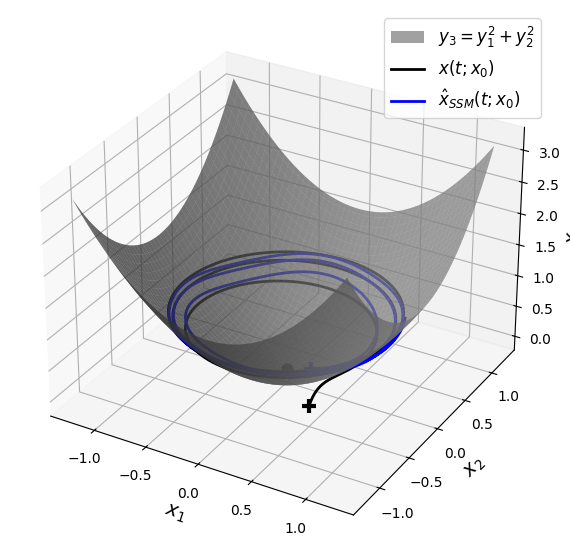

In [44]:
import matplotlib.pyplot as plt

# Plot the results

# Manifold
y1_critical, y2_critical = jnp.linspace(-1.25, 1.25, 100), jnp.linspace(-1.25, 1.25, 100)
y1_critical, y2_critical = jnp.meshgrid(y1_critical, y2_critical)
y3_critical = y1_critical**2 + y2_critical**2

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(y1_critical, y2_critical, y3_critical, color='grey', alpha=0.4, linewidth=2, label=r"", zorder=1)
ax.plot_surface(y1_critical, y2_critical, y3_critical, color='grey', alpha=0.6, linewidth=2, label=r"$y_3=y_1^2+y_2^2$", zorder=1)
ax.scatter(x0[0], x0[1], x0[2], color='black', marker='+', linewidth=3, s=100, label=r'', zorder=2)
ax.plot(x_true[:, 0], x_true[:, 1], x_true[:, 2], color='black', linewidth=2, label=r"$x(t;x_0)$", zorder=3)
ax.scatter(x_pred_orth[0, 0], x_pred_orth[1, 0], x_pred_orth[2, 0], color='blue', marker='+', linewidth=3, s=100, label=r'', zorder=4)
ax.plot(x_pred_orth[0, :], x_pred_orth[1, :], x_pred_orth[2, :], color='blue', linewidth=2, label=r"$\hat{x}_{SSM}(t;x_0)$", zorder=5)
ax.scatter(0, 0, 0, color='black', marker='o', s=60, label=r'', zorder=8)
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_zlabel('$x_3$', fontsize=14)
ax.legend(fontsize=12)

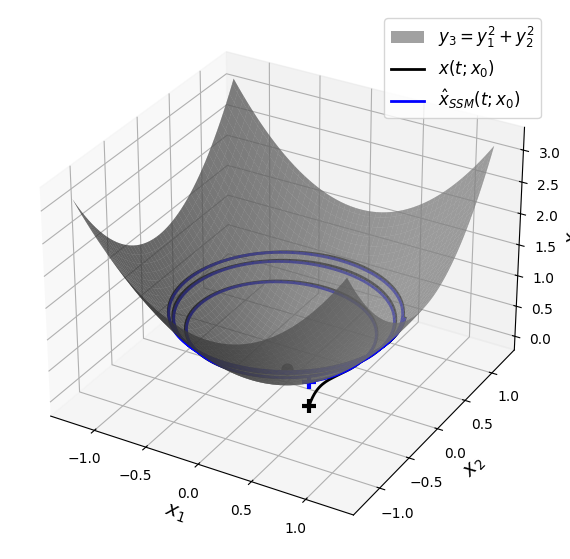

In [45]:
# Plot the results
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(y1_critical, y2_critical, y3_critical, color='grey', alpha=0.4, linewidth=2, label=r"", zorder=1)
ax.plot_surface(y1_critical, y2_critical, y3_critical, color='grey', alpha=0.6, linewidth=2, label=r"$y_3=y_1^2+y_2^2$", zorder=1)
ax.scatter(x0[0], x0[1], x0[2], color='black', marker='+', linewidth=3, s=100, label=r'', zorder=2)
ax.plot(x_true[:, 0], x_true[:, 1], x_true[:, 2], color='black', linewidth=2, label=r"$x(t;x_0)$", zorder=3)
ax.scatter(x_pred_opt[0, 0], x_pred_opt[1, 0], x_pred_opt[2, 0], color='blue', marker='+', linewidth=3, s=100, label=r'', zorder=4)
ax.plot(x_pred_opt[0, :], x_pred_opt[1, :], x_pred_opt[2, :], color='blue', linewidth=2, label=r"$\hat{x}_{SSM}(t;x_0)$", zorder=5)
ax.scatter(0, 0, 0, color='black', marker='o', s=60, label=r'', zorder=8)
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_zlabel('$x_3$', fontsize=14)
ax.legend(fontsize=12)